In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
from PIL import Image
# import tensorflow as tf
from sklearn import decomposition
import cv2
from sklearn.model_selection import train_test_split

In [27]:
LABELS =  ['call_me', 'fingers_crossed', 'okay', 'paper', 'peace', 'rock', 'rock_on', 'scissor', 'thumbs', 'up']
LABELS_TO_INDEX = {k: v for v, k in enumerate(LABELS)}
INDEX_TO_LABELS = {k: v for k, v in enumerate(LABELS)}

In [3]:
# if no dataset folder, extract it
if not os.path.exists('datasets/'):
    !unzip -q datasets.zip

In [17]:
images = []
train_labels = []
for label_name in LABELS:
    folder_path = 'datasets/HandGesture/images/' + label_name
    for filename in os.listdir(folder_path):
        img = Image.open(os.path.join(folder_path, filename))
        if img.mode != 'L':
            img = img.convert('L')
        img_arr = np.array(img)
        images.append(img_arr)
        train_labels.append(label_name)
images = np.array(images)
print(images.shape)

(5243, 195, 240)


In [26]:
img_shape = images[0].shape                         # 195 x 240
X = images.reshape(images.shape[0], -1)             # flatten 195 x 240 image
y = np.vectorize(LABELS_TO_INDEX.get)(train_labels) # convert label name to index (call_me -> 0)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (3670, 46800)
y_train (3670,)
X_test (1573, 46800)
y_test (1573,)


# Feature Extraction using PCA

In [ ]:
standardized_scalar = StandardScaler()
standardized_data = standardized_scalar.fit_transform(X)
standardized_data.shape

(5243, 46800)

In [ ]:
# cov_matrix = np.matmul(standardized_data.T, standardized_data)
# cov_matrix.shape

In [ ]:
pca = decomposition.PCA(n_components = 2)
principal_components = pca.fit_transform(standardized_data)

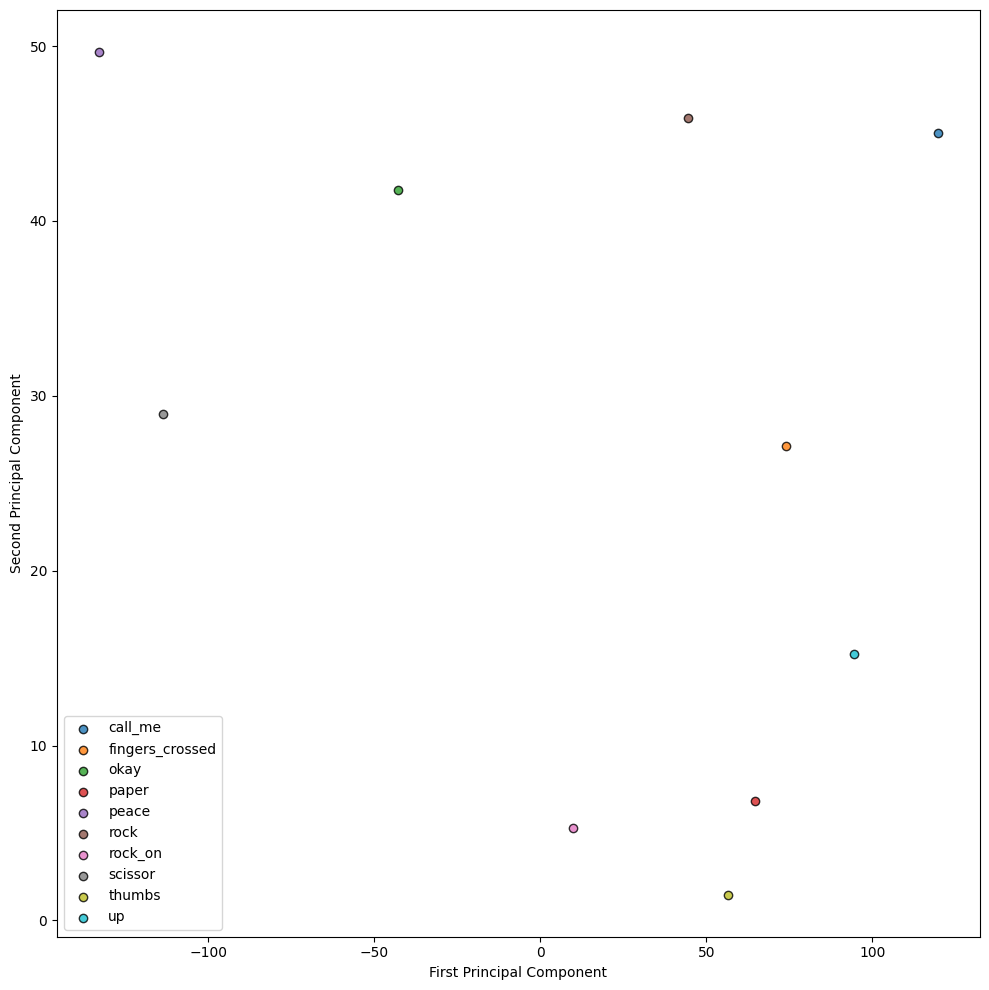

In [ ]:
plt.figure(figsize=(10, 10))

colors = plt.cm.tab10(np.linspace(0, 1, len(labels)))

for label, color in zip(labels, colors):
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(principal_components[indices, 0], principal_components[indices, 1], 
                c=[color], label=label, edgecolors='k', alpha=0.8)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Feature Extration with HOG

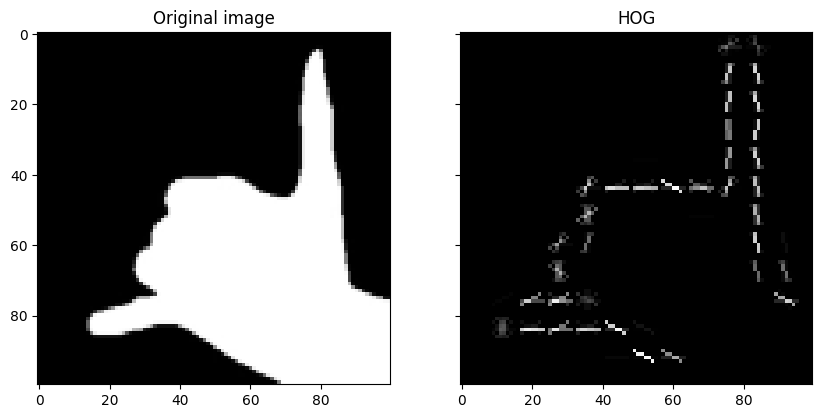

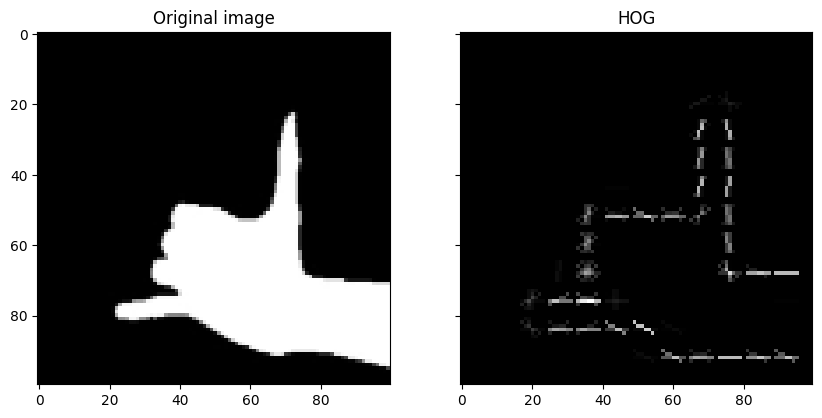

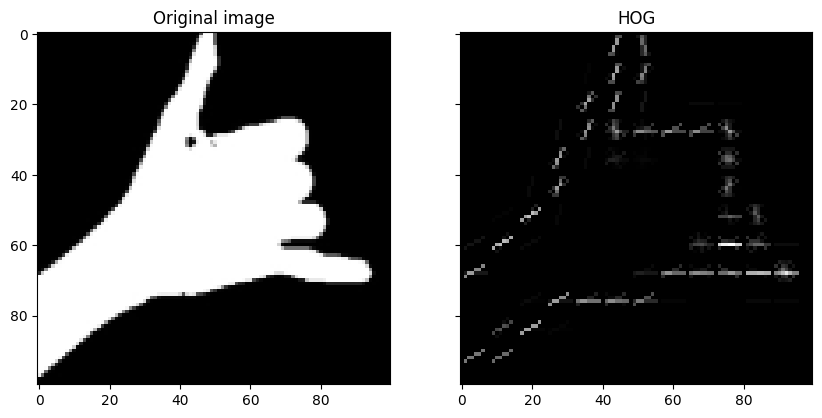

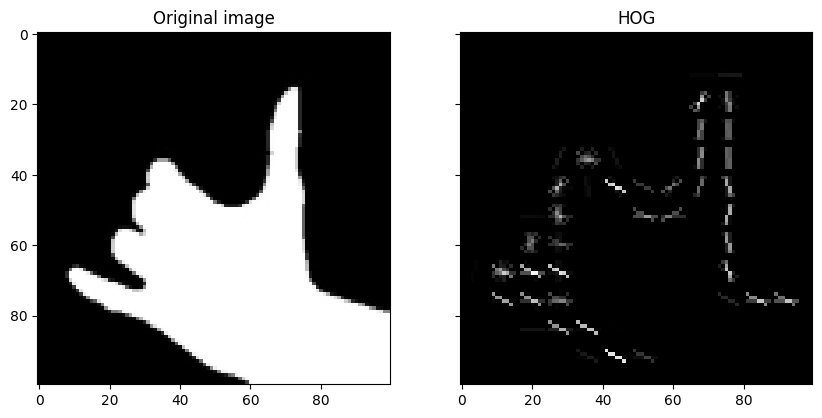

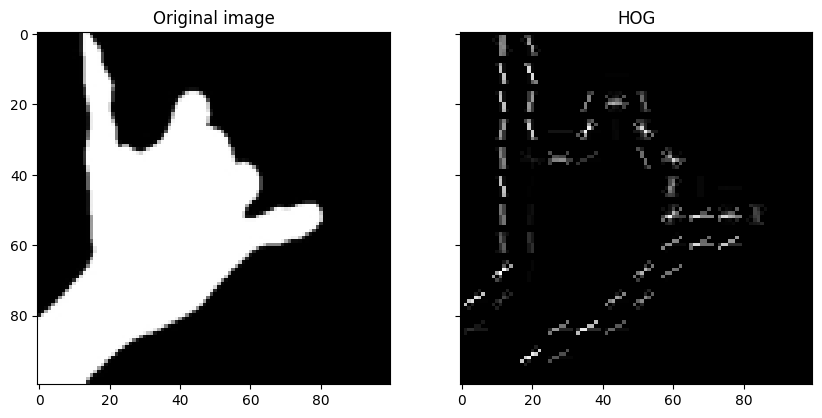

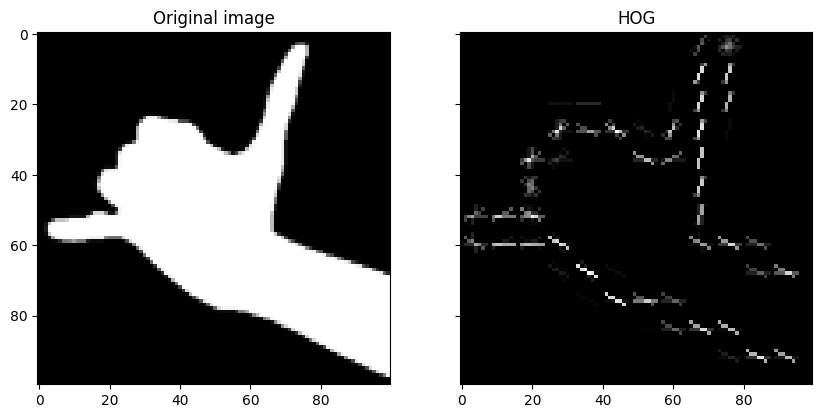

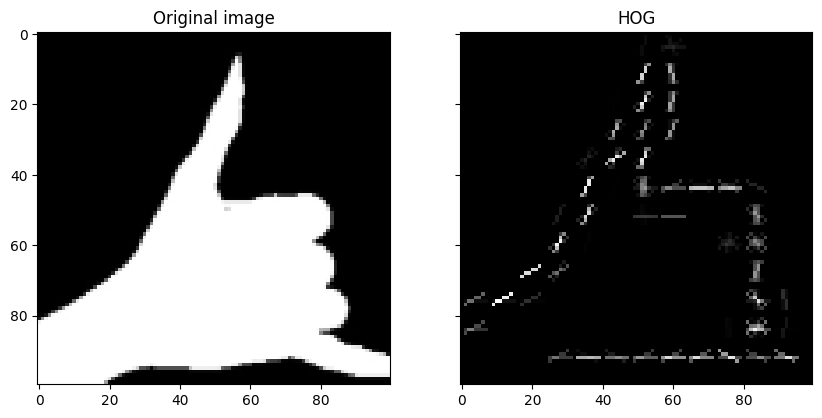

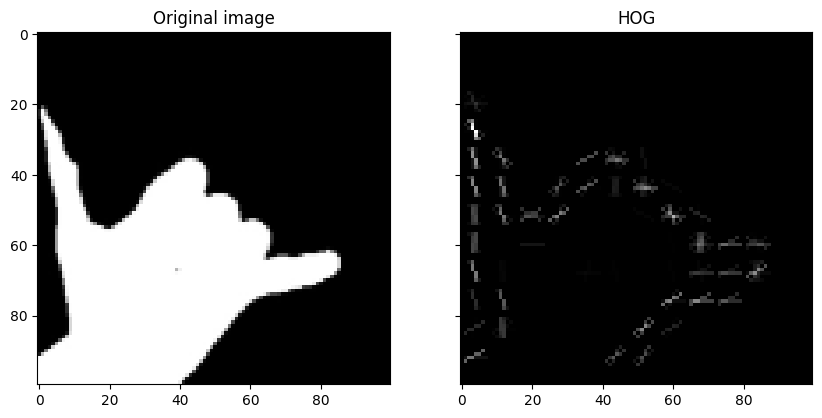

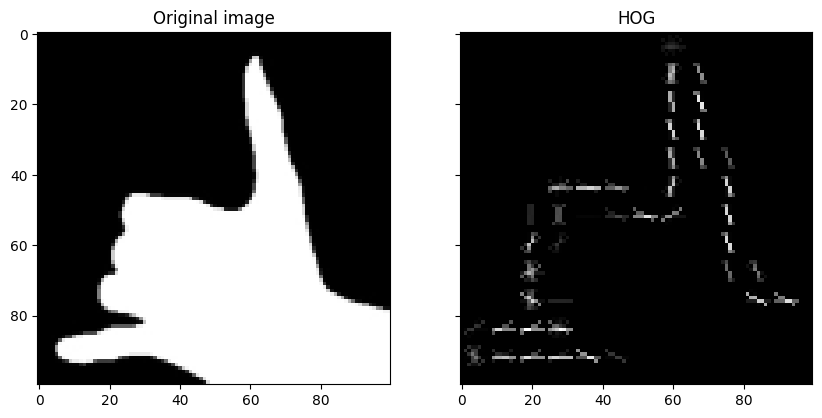

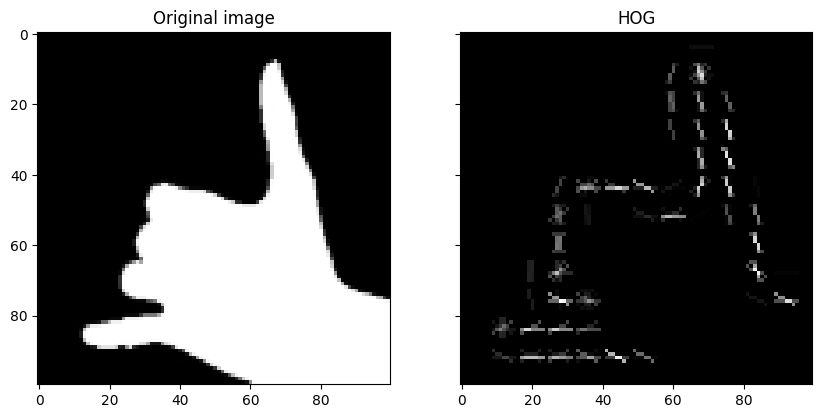

In [ ]:
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import data, exposure
import matplotlib.pyplot as plt
import io


fds = []
hog_img_list = []
ori_img_list = []

max_hog_display = 10  # Display 10 HOG images, change it if different number of HOG images is desired
count = 0

for i in range(len(images)):
    img_resized = resize(images[i], (100,100)) 

    fd, hog_img = hog(img_resized, orientations=9, pixels_per_cell=(8, 8), 
                        cells_per_block=(2, 2), visualize=True)
    
    fds.append(fd)
    
    if count < max_hog_display:
        hog_img_list.append(hog_img)
        ori_img_list.append(img_resized)
    
    count +=1
    

for i in range(len(hog_img_list)):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True) 

    ax1.imshow(ori_img_list[i], cmap=plt.cm.gray) 
    ax1.set_title('Original image') 

    # Rescale histogram
    hog_image_rescaled = exposure.rescale_intensity(hog_img_list[i], in_range=(0, 10)) 

    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
    ax2.set_title('HOG')

    plt.show()

# Classification Using K-Means

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(n_clusters=100)

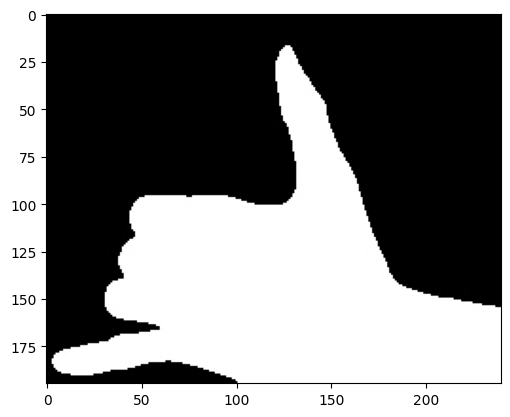

In [51]:
img = images[0] # warning: this is a uint8
plt.imshow(img, cmap=plt.cm.gray)

from sklearn.cluster import KMeans, MiniBatchKMeans

# Perform K Means
K = 100 # begin with 10 (number of gesture labels), increase to much much more as necessary
kmeans = MiniBatchKMeans(n_clusters = K)
kmeans.fit(X_train)

In [53]:
print(kmeans.labels_) # cluster labels for each training image
print(kmeans.cluster_centers_.shape) # K clusters x 46800 pixels

def visualize_all_clusters(kmeans):
    for i in range(len(kmeans.cluster_centers_)):
        center = kmeans.cluster_centers_[i].reshape((img_shape))
        plt.imshow(center)
        plt.show()

# for each KMeans cluster, get the most probable label
# return mapping from cluster to label
def cluster_to_index(cluster_labels, y_train):
    index_labels = {}
    for i in range(len(np.unique(kmeans.labels_))):
        index = np.where(cluster_labels == i,1,0)
        num = np.bincount(y_train[index==1]).argmax()
        index_labels[i] = num
    return index_labels

CLUSTERS_TO_INDEX = cluster_to_index(kmeans.labels_, y_train)
print(CLUSTERS_TO_INDEX)

[48 28 65 ... 25 67 69]
(100, 46800)
{0: 2, 1: 6, 2: 4, 3: 0, 4: 0, 5: 8, 6: 4, 7: 8, 8: 7, 9: 1, 10: 1, 11: 6, 12: 0, 13: 4, 14: 9, 15: 1, 16: 7, 17: 7, 18: 5, 19: 4, 20: 2, 21: 3, 22: 8, 23: 7, 24: 1, 25: 3, 26: 9, 27: 9, 28: 6, 29: 6, 30: 0, 31: 0, 32: 7, 33: 0, 34: 7, 35: 1, 36: 5, 37: 2, 38: 9, 39: 9, 40: 0, 41: 9, 42: 5, 43: 6, 44: 2, 45: 0, 46: 3, 47: 8, 48: 6, 49: 9, 50: 8, 51: 5, 52: 2, 53: 8, 54: 0, 55: 8, 56: 0, 57: 6, 58: 0, 59: 2, 60: 4, 61: 2, 62: 5, 63: 5, 64: 4, 65: 7, 66: 3, 67: 1, 68: 9, 69: 5, 70: 3, 71: 0, 72: 8, 73: 6, 74: 1, 75: 7, 76: 2, 77: 6, 78: 3, 79: 2, 80: 7, 81: 0, 82: 0, 83: 2, 84: 8, 85: 7, 86: 1, 87: 4, 88: 0, 89: 9, 90: 8, 91: 5, 92: 6, 93: 5, 94: 8, 95: 0, 96: 4, 97: 8, 98: 5, 99: 3}


In [61]:
# Get test results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

cluster_ids = kmeans.predict(X_test)
y_pred = np.vectorize(CLUSTERS_TO_INDEX.get)(cluster_ids)

print('Accuracy:',  accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='micro'))
print('Recall:',    recall_score(y_test, y_pred, average='micro'))
print('F1:',        f1_score(y_test, y_pred, average='micro'))

Accuracy: 0.5066751430387794
Precision: 0.5066751430387794
Recall: 0.5066751430387794
F1: 0.5066751430387794


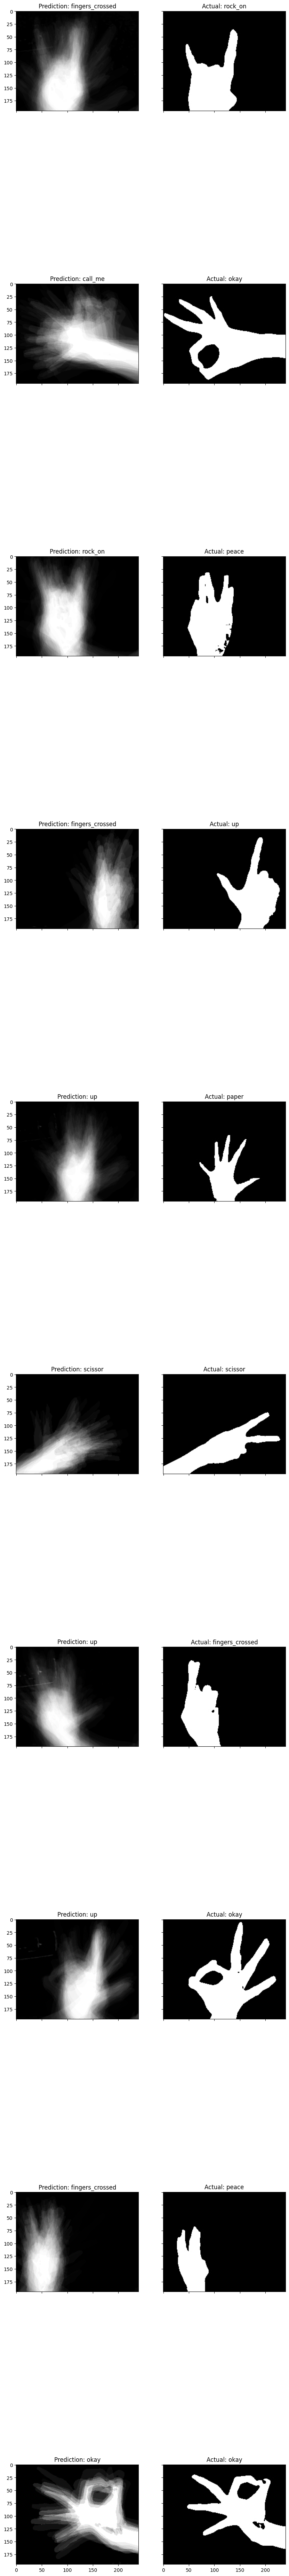

In [55]:
# take 10 test images, predict them, and display them
N = 10
fig, axs = plt.subplots(N, 2, sharex='all', sharey='all', figsize=(10, 10*N))

imgs = X_test[:N]
cluster_ids = kmeans.predict(imgs) # cluster index

for i in range(N):
    img = imgs[i]
    cluster_id = cluster_ids[i]
    cluster = kmeans.cluster_centers_[cluster_id].reshape((img_shape)) # cluster image

    true_label = INDEX_TO_LABELS[y_test[i]]
    pred_label = INDEX_TO_LABELS[CLUSTERS_TO_INDEX[cluster_id]]

    axs[i, 0].imshow(cluster, cmap=plt.cm.gray)
    axs[i, 0].set_title('Prediction: {}'.format(pred_label))

    axs[i, 1].imshow(img.reshape((img_shape)), cmap=plt.cm.gray)
    axs[i, 1].set_title('Actual: {}'.format(true_label))